# Optimize Forward Step (3)

Test the running time for 2 forward steps in variational autoencoder by comparing 4 versions:
- Tensorflow 
- numpy only
- numpy with numba
- numpy with cython  

Compare the results in different batch sizes

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import time
from tensorflow.python.client import timeline
import matplotlib.pyplot as plt
%matplotlib inline

### Initialize Parameters

In [2]:
import sys
sys.path.append('../')
from vae_sta663 import *
from misc_sta663 import *

In [6]:
import tensorflow as tf
import numpy as np

config = {}
config['x_in'] = 784
config['encoder_1'] = 500
config['encoder_2'] = 500
config['decoder_1'] = 500
config['decoder_2'] = 500
config['z'] = 20

encoder_weights, decoder_weights = init_weights(config)

In [7]:
# transform tensors to numpy array
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

encoder_weights_np = {}
encoder_weights_np['h1'] = sess.run(encoder_weights['h1'])
encoder_weights_np['h2'] = sess.run(encoder_weights['h2'])
encoder_weights_np['mu'] = sess.run(encoder_weights['mu'])
encoder_weights_np['sigma'] = sess.run(encoder_weights['sigma'])
encoder_weights_np['b1'] = sess.run(encoder_weights['b1'])
encoder_weights_np['b2'] = sess.run(encoder_weights['b2'])
encoder_weights_np['bias_mu'] = sess.run(encoder_weights['bias_mu'])
encoder_weights_np['bias_sigma'] = sess.run(encoder_weights['bias_sigma'])

decoder_weights_np = {}
decoder_weights_np['h1'] = sess.run(decoder_weights['h1'])
decoder_weights_np['h2'] = sess.run(decoder_weights['h2'])
decoder_weights_np['mu'] = sess.run(decoder_weights['mu'])
decoder_weights_np['sigma'] = sess.run(decoder_weights['sigma'])
decoder_weights_np['b1'] = sess.run(decoder_weights['b1'])
decoder_weights_np['b2'] = sess.run(decoder_weights['b2'])
decoder_weights_np['bias_mu'] = sess.run(decoder_weights['bias_mu'])
decoder_weights_np['bias_sigma'] = sess.run(decoder_weights['bias_sigma'])

In [8]:
(mnist, n_samples) = mnist_loader()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Tensorflow

In [15]:
def forward_tf(x, encoder_weights, decoder_weights, batch_size):
    """
    forward step in vae
    """
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, encoder_weights['h1']), encoder_weights['b1']))
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, encoder_weights['h2']), encoder_weights['b2']))
    z_mean = tf.add(tf.matmul(layer_2, encoder_weights['mu']), encoder_weights['bias_mu'])
    z_sigma = tf.add(tf.matmul(layer_2, encoder_weights['sigma']), encoder_weights['bias_sigma'])
    
    # compute z by drawing sample from normal distribution
    eps = tf.random_normal((batch_size, 20), 0, 1, dtype=tf.float32)
    z_val = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_sigma)), eps))
    
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(z_val, decoder_weights['h1']), decoder_weights['b1']))
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, decoder_weights['h2']), decoder_weights['b2']))
    x_prime = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, decoder_weights['mu']), decoder_weights['bias_mu']))
    
    return x_prime

In [16]:
batch_size = 100
x_sample, _ = mnist.train.next_batch(batch_size)
x_sample_tf = tf.constant(x_sample)

In [17]:
%timeit -n10 -r3 sess.run(forward_tf(x_sample_tf, encoder_weights, decoder_weights, batch_size))

10 loops, best of 3: 30.2 ms per loop


### Numpy Only

In [20]:
def forward_numpy(x, encoder_weights_np, decoder_weights_np, batch_size):
    """
    forward step in vae
    """
    layer_1 = np.log(np.exp(x_sample @ encoder_weights_np['h1'] + encoder_weights_np['b1']) + 1)
    layer_2 = np.log(np.exp(layer_1 @ encoder_weights_np['h2'] + encoder_weights_np['b2']) + 1)
    z_mean = (layer_2 @ encoder_weights_np['mu'] + encoder_weights_np['bias_mu'])
    z_sigma = (layer_2 @ encoder_weights_np['sigma'] + encoder_weights_np['bias_sigma'])
    
    # compute z by drawing sample from normal distribution
    eps = np.random.normal(0, 1, (batch_size, 20))
    z_val = z_mean + np.multiply(np.sqrt(np.exp(z_sigma)), eps)
    
    layer_1 = np.log(np.exp(z_val @ decoder_weights_np['h1'] + decoder_weights_np['b1']) + 1)
    layer_2 = np.log(np.exp(layer_1 @ decoder_weights_np['h2'] + decoder_weights_np['b2']) + 1)
    x_prime = 1/(1 + np.exp(-layer_2 @ decoder_weights_np['mu'] - decoder_weights_np['bias_mu']))
    
    return(x_prime)

In [21]:
%timeit -n10 -r3 forward_numpy(x_sample, encoder_weights_np, decoder_weights_np, batch_size)

10 loops, best of 3: 15 ms per loop


### Numpy with Numba

In [36]:
import numba
from numba import jit, vectorize, float32, float64

@jit('float32[:,:](float64[:,:],float64[:,:])')
def mat_mul(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k,j]
    return C

@vectorize([float64(float64)])
def soft_plus(x):
    """
    Vectorize version of numba
    """
    return np.log(np.exp(x) + 1)

@jit('float64[:,:](float64[:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],float64[:,:],int32)')
def forward_numba(x, encoder_weights_h1, encoder_weights_h2, encoder_weights_b1, encoder_weights_b2, encoder_weights_mu, 
                    encoder_weights_bias_mu, encoder_weights_sigma, encoder_weights_bias_sigma, decoder_weights_h1,
                    decoder_weights_h2, decoder_weights_b1, decoder_weights_b2, decoder_weights_mu,
                    decoder_weights_bias_mu, batch_size):
    """
    Compute mean and sigma of z using numpy without any optimization
    """
    layer_1 = soft_plus(mat_mul(x, encoder_weights_h1) + encoder_weights_b1)
    layer_2 = soft_plus(mat_mul(layer_1, encoder_weights_h2) + encoder_weights_b2)
    z_mean = (mat_mul(layer_2, encoder_weights_mu) + encoder_weights_bias_mu)
    z_sigma = (mat_mul(layer_2, encoder_weights_sigma) + encoder_weights_bias_sigma)
    
    # compute z by drawing sample from normal distribution
    eps = np.random.normal(0, 1, (batch_size, 20))
    z_val = z_mean + np.multiply(np.sqrt(np.exp(z_sigma)), eps)
    
    layer_1 = soft_plus(mat_mul(z_val, decoder_weights_h1) + decoder_weights_b1)
    layer_2 = soft_plus(mat_mul(layer_1, decoder_weights_h2) + decoder_weights_b2)
    x_prime = 1/(1 + np.exp(-mat_mul(layer_2, decoder_weights_mu) - decoder_weights_bias_mu))
    
    return(x_prime)

In [37]:
%%timeit -n10 -r3 
forward_numba(x_sample, encoder_weights_np['h1'], encoder_weights_np['h2'], encoder_weights_np['b1'], 
              encoder_weights_np['b2'], encoder_weights_np['mu'], encoder_weights_np['bias_mu'], 
              encoder_weights_np['sigma'], encoder_weights_np['bias_sigma'], decoder_weights_np['h1'], 
              decoder_weights_np['h2'], decoder_weights_np['b1'], decoder_weights_np['b2'], 
              decoder_weights_np['mu'], decoder_weights_np['bias_mu'], batch_size)

10 loops, best of 3: 358 ms per loop


### Numpy with Cython

In [38]:
%load_ext Cython

In [54]:
%%cython -a
cimport cython
import numpy as np
from libc.math cimport exp, log, sqrt

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] mat_mul_cython(double[:,:] A, double[:,:] B):
    """Matrix multiply function. Cythonize"""
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int p = B.shape[1]
    cdef int i,j,k
    cdef double[:,:] C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k,j]
    return C

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] mat_mul_ele_cython(double[:,:] A, double[:,:] B):
    """Matrix element-wise multiply function. Cythonize"""
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int i,j
    cdef double[:,:] C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            C[i,j] = A[i,j] * B[i,j]
    return C

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] mat_add_cython(double[:,:] A, double[:] B):
    """Matrix multiply function. Cythonize"""
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int i,j
    cdef double[:,:] C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            C[i,j] = A[i,j] + B[j]
    return C

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] mat_add_cython_2d(double[:,:] A, double[:,:] B):
    """Matrix multiply function. Cythonize"""
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int i,j
    cdef double[:,:] C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            C[i,j] = A[i,j] + B[i,j]
    return C

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] sqrt_cython(double[:,:] x):
    cdef int m = x.shape[0]
    cdef int n = x.shape[1]
    cdef double[:,:] y = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            y[i,j] = sqrt(x[i,j])
    return y

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] exp_cython(double[:,:] x):
    cdef int m = x.shape[0]
    cdef int n = x.shape[1]
    cdef double[:,:] y = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            y[i,j] = exp(x[i,j])
    return y

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] soft_plus_cython(double[:,:] x):
    cdef int m = x.shape[0]
    cdef int n = x.shape[1]
    cdef double[:,:] y = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            y[i,j] = log(exp(x[i,j])+1)
    return y

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:,:] sigmoid_cython(double[:,:] x):
    cdef int m = x.shape[0]
    cdef int n = x.shape[1]
    cdef double[:,:] y = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            y[i,j] = 1/(1+log(-x[i,j]))
    return y

@cython.wraparound(False)
@cython.boundscheck(False)
def forward_cython(double[:,:] x, double[:,:] encoder_weights_h1, double[:,:] encoder_weights_h2, 
                     double[:] encoder_weights_b1, double[:] encoder_weights_b2, double [:,:] encoder_weights_mu, 
                     double[:] encoder_weights_bias_mu, double[:,:] encoder_weights_sigma, 
                     double[:] encoder_weights_bias_sigma, double[:,:] decoder_weights_h1,
                     double[:,:] decoder_weights_h2, double[:] decoder_weights_b1, 
                     double[:] decoder_weights_b2, double[:,:] decoder_weights_mu,
                     double[:] decoder_weights_bias_mu, int batch_size):
    """
    Compute mean and sigma of z using numpy with cython optimization
    """
    cdef double[:,:] layer_1 = soft_plus_cython(mat_add_cython(mat_mul_cython(x, encoder_weights_h1), encoder_weights_b1))
    cdef double[:,:] layer_2 = soft_plus_cython(mat_add_cython(mat_mul_cython(layer_1, encoder_weights_h2), encoder_weights_b2))
    cdef double[:,:] z_mean = mat_add_cython(mat_mul_cython(layer_2, encoder_weights_mu), encoder_weights_bias_mu)
    cdef double[:,:] z_sigma = mat_add_cython(mat_mul_cython(layer_2, encoder_weights_sigma), encoder_weights_bias_sigma)
    
    # compute z by drawing sample from normal distribution
    cdef double[:,:] eps = np.random.normal(0, 1, (batch_size, 20))
    cdef double[:,:] z_val = mat_add_cython_2d(mat_mul_ele_cython(sqrt_cython(exp_cython(z_sigma)), eps), z_mean)
    
    cdef double[:,:] layer_3 = soft_plus_cython(mat_add_cython(mat_mul_cython(z_val, decoder_weights_h1), decoder_weights_b1))
    cdef double[:,:] layer_4 = soft_plus_cython(mat_add_cython(mat_mul_cython(layer_3, decoder_weights_h2), decoder_weights_b2))
    cdef double[:,:] x_prime = sigmoid_cython(mat_add_cython(mat_mul_cython(layer_4, decoder_weights_mu), decoder_weights_bias_mu))
    
    return(np.array(x_prime))

In [53]:
x_sample_cython = x_sample.astype(np.float64)
encoder_weights_cython = {}
encoder_weights_cython['h1'] = encoder_weights_np['h1'].astype(np.float64)
encoder_weights_cython['h2'] = encoder_weights_np['h2'].astype(np.float64)
encoder_weights_cython['b1'] = encoder_weights_np['b1'].astype(np.float64)
encoder_weights_cython['b2'] = encoder_weights_np['b2'].astype(np.float64)
encoder_weights_cython['mu'] = encoder_weights_np['mu'].astype(np.float64)
encoder_weights_cython['bias_mu'] = encoder_weights_np['bias_mu'].astype(np.float64)
encoder_weights_cython['sigma'] = encoder_weights_np['sigma'].astype(np.float64)
encoder_weights_cython['bias_sigma'] = encoder_weights_np['bias_sigma'].astype(np.float64)

decoder_weights_cython = {}
decoder_weights_cython['h1'] = decoder_weights_np['h1'].astype(np.float64)
decoder_weights_cython['h2'] = decoder_weights_np['h2'].astype(np.float64)
decoder_weights_cython['b1'] = decoder_weights_np['b1'].astype(np.float64)
decoder_weights_cython['b2'] = decoder_weights_np['b2'].astype(np.float64)
decoder_weights_cython['mu'] = decoder_weights_np['mu'].astype(np.float64)
decoder_weights_cython['bias_mu'] = decoder_weights_np['bias_mu'].astype(np.float64)

In [56]:
%%timeit -n10 -r3 
forward_cython(x_sample_cython, encoder_weights_cython['h1'], encoder_weights_cython['h2'], encoder_weights_cython['b1'], 
              encoder_weights_cython['b2'], encoder_weights_cython['mu'], encoder_weights_cython['bias_mu'], 
              encoder_weights_cython['sigma'], encoder_weights_cython['bias_sigma'], decoder_weights_cython['h1'],
              decoder_weights_cython['h2'], decoder_weights_cython['b1'], decoder_weights_cython['b2'],
              decoder_weights_cython['mu'], decoder_weights_cython['bias_mu'], batch_size)

10 loops, best of 3: 179 ms per loop


### Test on Different Batch Sizes

In [57]:
batch_size = np.arange(50, 1000, 50)
run_time_best = np.zeros((4, batch_size.shape[0]))
run_time_worst = np.zeros((4, batch_size.shape[0]))

In [59]:
for cnt, s in enumerate(batch_size):
    print('Evaluating at: %d' % s)
    
    x_sample, _ = mnist.train.next_batch(s)
    x_sample_tf = tf.constant(x_sample)
    x_sample_cython = x_sample.astype(np.float64)
    
    result_1 = %timeit -o -n10 -r3 sess.run(forward_tf(x_sample_tf, encoder_weights, decoder_weights, s))
    run_time_best[0,cnt] = result_1.best
    run_time_worst[0, cnt] = result_1.worst
    
    result_2 = %timeit -o -n10 -r3 forward_numpy(x_sample, encoder_weights_np, decoder_weights_np, s)
    run_time_best[1,cnt] = result_2.best
    run_time_worst[1, cnt] = result_2.worst
    
    result_3 = %timeit -o -n10 -r3 forward_numba(x_sample, encoder_weights_np['h1'], encoder_weights_np['h2'], encoder_weights_np['b1'], encoder_weights_np['b2'], encoder_weights_np['mu'], encoder_weights_np['bias_mu'], encoder_weights_np['sigma'], encoder_weights_np['bias_sigma'], decoder_weights_np['h1'], decoder_weights_np['h2'], decoder_weights_np['b1'], decoder_weights_np['b2'], decoder_weights_np['mu'], decoder_weights_np['bias_mu'], s)
    run_time_best[2,cnt] = result_3.best
    run_time_worst[2, cnt] = result_3.worst
    
    result_4 = %timeit -o -n10 -r3 forward_cython(x_sample_cython, encoder_weights_cython['h1'], encoder_weights_cython['h2'], encoder_weights_cython['b1'], encoder_weights_cython['b2'], encoder_weights_cython['mu'], encoder_weights_cython['bias_mu'], encoder_weights_cython['sigma'], encoder_weights_cython['bias_sigma'], decoder_weights_cython['h1'], decoder_weights_cython['h2'], decoder_weights_cython['b1'], decoder_weights_cython['b2'], decoder_weights_cython['mu'], decoder_weights_cython['bias_mu'], s)
    run_time_best[3,cnt] = result_4.best
    run_time_worst[3, cnt] = result_4.worst

Evaluating at: 50s
10 loops, best of 3: 49.7 ms per loop
10 loops, best of 3: 13 ms per loop
10 loops, best of 3: 187 ms per loop
10 loops, best of 3: 104 ms per loop
Evaluating at: 100s
10 loops, best of 3: 63 ms per loop
10 loops, best of 3: 19 ms per loop
10 loops, best of 3: 396 ms per loop
10 loops, best of 3: 202 ms per loop
Evaluating at: 150s
10 loops, best of 3: 74.8 ms per loop
10 loops, best of 3: 24.9 ms per loop
10 loops, best of 3: 598 ms per loop
10 loops, best of 3: 301 ms per loop
Evaluating at: 200s
10 loops, best of 3: 90.9 ms per loop
10 loops, best of 3: 32.3 ms per loop
10 loops, best of 3: 796 ms per loop
10 loops, best of 3: 406 ms per loop
Evaluating at: 250s
10 loops, best of 3: 118 ms per loop
10 loops, best of 3: 38.4 ms per loop
10 loops, best of 3: 996 ms per loop
10 loops, best of 3: 501 ms per loop
Evaluating at: 300s
10 loops, best of 3: 133 ms per loop
10 loops, best of 3: 48.2 ms per loop
10 loops, best of 3: 1.2 s per loop
10 loops, best of 3: 599 ms

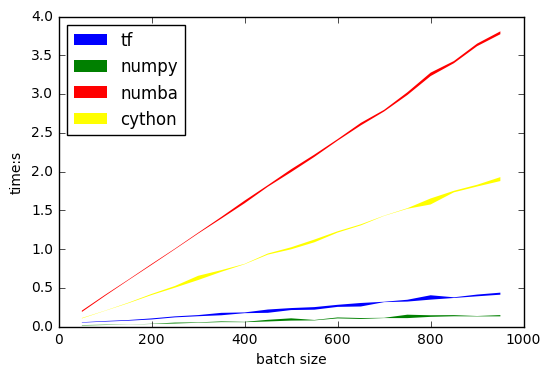

In [60]:
plt.fill_between(batch_size, run_time_worst[0,:], run_time_best[0,:], facecolor='blue', color='none', label='tf')
plt.fill_between(batch_size, run_time_worst[1,:], run_time_best[1,:], facecolor='green', color='none', label='numpy')
plt.fill_between(batch_size, run_time_worst[2,:], run_time_best[2,:], facecolor='red', color='none', label='numba')
plt.fill_between(batch_size, run_time_worst[3,:], run_time_best[3,:], facecolor='yellow', color='none', label='cython')

plt.xlabel('batch size')
plt.ylabel('time:s')
plt.legend(loc='upper left')

plt.show()